Step 1 Data Acquisition and Visualization (10 pts):

In [1]:
import numpy as np
import gzip
import struct

import matplotlib.pyplot as plt

(a) Download the “MNIST” dataset and extract the files. You will get four files with extension .gz

You can use the provided function read_idx below to read in the dataset. As its official description, the dataset is split into 60000 training images and 10000 images. The four file corresponds to the training images, training labels, testing images and testing labels. You need to print out their shape to finish this step.

In [2]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

trainLb = read_idx(filename='train-labels-idx1-ubyte.gz')
trainImg = read_idx(filename='train-images-idx3-ubyte.gz')
t10k_Lb = read_idx(filename='t10k-labels-idx1-ubyte.gz')
t10k_Img = read_idx(filename='t10k-images-idx3-ubyte.gz')

trainImg = np.array(trainImg)
trainLb = np.array(trainLb)
t10k_Lb = np.array(t10k_Lb)
t10k_Img = np.array(t10k_Img)

# Print shapes of the datasets
print("Training Images Shape:", trainImg.shape)
print("Training Labels Shape:", trainLb.shape)
print("Testing Images Shape:", t10k_Img.shape)
print("Testing Labels Shape:", t10k_Lb.shape)

Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Testing Images Shape: (10000, 28, 28)
Testing Labels Shape: (10000,)


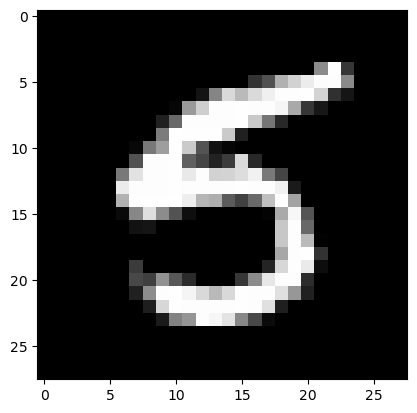

In [3]:
plt.imshow(trainImg[np.random.randint(5000)], cmap='gray')

Step 2 Data Preprocessing (10 pts): In this step, you need to:

a) Normalize the pixel values of images to be between 0 and 1. (5 pts)

In [4]:
# Normalize pixel values to be between 0 and 1
trainImg = trainImg.astype('float32') / 255.0
t10k_Img = t10k_Img.astype('float32') / 255.0

# Print shapes
print("Training Images Shape (Normalized):", trainImg.shape)
print("Testing Images Shape (Normalized):", t10k_Img.shape)


Training Images Shape (Normalized): (60000, 28, 28)
Testing Images Shape (Normalized): (10000, 28, 28)


b) Convert the labels from categorical data into numerical values using one-hot encoding.

In [5]:
# Convert labels to one-hot encoding
trainLb
categories = trainLb

uniques, ids = np.unique(categories, return_inverse=True)

cat_encode = np.eye(len(uniques))[ids]

cat_encode.shape

(60000, 10)

Step 3 Network Initialization (10 pts): We will work with a neuron network with
two hidden layers, using Sigmoid function as the activation functions for hidden
layers and softmax activation function for the output layer. To finish this, you
need to:

(a) Identify the auxiliary input including the Sigmoid function and its derivative and
Softmax function (5 pts)

In [6]:
# define sigmoid, sigmoid derivative and softmax function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

(b) Initialize all the parameters in neural network uniformly. In this network, the input size is 784 dimensions (each input is a 28x28 image, so you have to flatten the data from 2D to 1D). For the two linear hidden layers, we have 128 and 64 neurons respectively. For the output layer, its size will be 10 since there are 10 classes (0-9) in MNIST. To finish this step, you need to initialize the weights and bias in random with a pre-set random seed using Numpy. Please set the seed value = 695. (5 pts)

In [7]:
# Initialize all the parameters in neural network uniformly

np.random.seed(695)  # Set the seed 695 as mentioned in question

# Initialize weights uniformly with small values
limit_w1 = np.sqrt(6 / (784 + 128))
limit_w2 = np.sqrt(6 / (128 + 64))
limit_w3 = np.sqrt(6 / (64 + 10))

weights = {
    'w1': np.random.uniform(-limit_w1, limit_w1, (784, 128)),
    'w2': np.random.uniform(-limit_w2, limit_w2, (128, 64)),
    'w3': np.random.uniform(-limit_w3, limit_w3, (64, 10))
}

# Initialize biases with zeros
biases = {
    'b1': np.zeros(128),
    'b2': np.zeros(64),
    'b3': np.zeros(10)
}

# Print out shapes to confirm initialization
for layer, w in weights.items():
    print(f"Shape of weights {layer}: {w.shape}")
for layer, b in biases.items():
    print(f"Shape of biases {layer}: {b.shape}")

Shape of weights w1: (784, 128)
Shape of weights w2: (128, 64)
Shape of weights w3: (64, 10)
Shape of biases b1: (128,)
Shape of biases b2: (64,)
Shape of biases b3: (10,)


Step 4 Feed Forward (10 pts): In this step, you need to:

(a) define a function named feed_forward. Given an input x, it should output the sigmoid of wx+b where w and b indicates the weights and bias defined in step 2. (5 pts)

In [8]:
# Define the Feed Forward Propagation

def feed_forward(x, weights, biases):
    
    # Flatten the image from 28x28 to 784
    x_flat = x.reshape(-1, 784)
    
    # Input layer to first hidden layer
    z1 = np.dot(x_flat, weights['w1']) + biases['b1']
    a1 = sigmoid(z1)

    # First hidden layer to second hidden layer
    z2 = np.dot(a1, weights['w2']) + biases['b2']
    a2 = sigmoid(z2)

    # Second hidden layer to output layer
    z3 = np.dot(a2, weights['w3']) + biases['b3']
    a3 = softmax(z3)

    # Storing the activations in a dictionary to use during backpropagation
    activations = {
        'a1': a1,
        'a2': a2,
        'a3': a3
    }
    
    return activations


Step 5 Back Propagation (15 pts): In this step, you need to implement the back propagation:

(a) You need to compute the loss for the output layer first. Here, we use categorical cross entropy loss function given below for multi-class classification problem. (5 pts) Note, to achieve this, you need to first encode the categorical labels as numerical values using one-hot encoding finished in step 2. (5 pts)

In [9]:
# Implement back propagation, including the calculation of the loss and gradients

def back_propagation(x, y, weights, biases, activations):
   
    # Calculate the number of examples
    m = x.shape[0]
    
    # Derivative of the loss w.r.t the last layer activation (softmax)
    dA3 = activations['a3'] - y
    
    # Gradients for the weights and biases of the third layer
    dW3 = np.dot(activations['a2'].T, dA3) / m
    db3 = np.sum(dA3, axis=0, keepdims=True) / m
    
    # Backprop into second layer
    dA2 = np.dot(dA3, weights['w3'].T) * sigmoid_derivative(activations['a2'])
    dW2 = np.dot(activations['a1'].T, dA2) / m
    db2 = np.sum(dA2, axis=0, keepdims=True) / m
    
    # Backprop into first layer
    dA1 = np.dot(dA2, weights['w2'].T) * sigmoid_derivative(activations['a1'])
    dW1 = np.dot(x.T, dA1) / m
    db1 = np.sum(dA1, axis=0, keepdims=True) / m
    

    # The gradients for each layer
    gradients = {
        'dW3': dW3,
        'db3': db3,
        'dW2': dW2,
        'db2': db2,
        'dW1': dW1,
        'db1': db1
    }
    
    # Calculate the categorical cross-entropy loss
    loss = -np.mean(np.sum(y * np.log(activations['a3'] + 1e-8), axis=1))
    
    return gradients, loss


Step 6 Model Training (15 pts): In this step, you need to:

(a) Use mini-batch gradient descent to update the parameters including weights and bias. Notice that a complete training round consists of a feed forward process, back propagation and parameter update.  Define the batch size = 128 and epoch = 100.

In [10]:

def update_parameters(weights, biases, gradients, learning_rate):

    for key in weights.keys():
        weights[key] = weights[key] - learning_rate * gradients['dW' + key[1:]]
    for key in biases.keys():
        biases[key] = biases[key] - learning_rate * gradients['db' + key[1:]]



def train_model(X_train, Y_train, weights, biases, batch_size, epochs, learning_rate):
    history = {'loss': []}  # To store the loss at each epoch

    for epoch in range(epochs):
        # Shuffle the training data (good practice for mini-batch gradient descent)
        permutation = np.random.permutation(12800)
        X_train_shuffled = X_train[permutation]
        Y_train_shuffled = Y_train[permutation]

        epoch_loss = 0

        # Mini-batch gradient descent
        for i in range(0, 12800, batch_size):
            # Creating mini-batch
            X_batch = X_train_shuffled[i:i + batch_size]
            Y_batch = Y_train_shuffled[i:i + batch_size]
            
            XY = 0
           
            # Perform a feedforward pass
            activations = feed_forward(X_batch, weights, biases)

            # Perform backpropagation to get the gradients
            gradients, loss = back_propagation(X_batch, Y_batch, weights, biases, activations)
         
            # Update parameters
            update_parameters(weights, biases, gradients, learning_rate)
            
            epoch_loss += loss

        # Calculate the loss for this epoch and store it
        
        epoch_loss /= (12800 / batch_size)
        history['loss'].append(epoch_loss)

    return weights, biases, history

batch_size = 128
epochs = 100
learning_rate = 0.5

trainImg = trainImg.reshape(60000,784)
train_weights, train_biases, train_history = train_model(trainImg, cat_encode, weights, biases, batch_size, epochs, learning_rate)

Step 7 Model Evaluation (10 pts): In this step, you need to:

(a) Use your trained neural network to predict the labels of the test dataset and compute the accuracy on the test dataset. (5 pts)
Remark: if you correctly execute every step above, you will probably get a result around 90%.

(b) Plot some of the misclassified images with their predicted and true labels. (5 pts) This probably can give you some insights into why these images are misclassified.

Accuracy on the test dataset: 91.57%


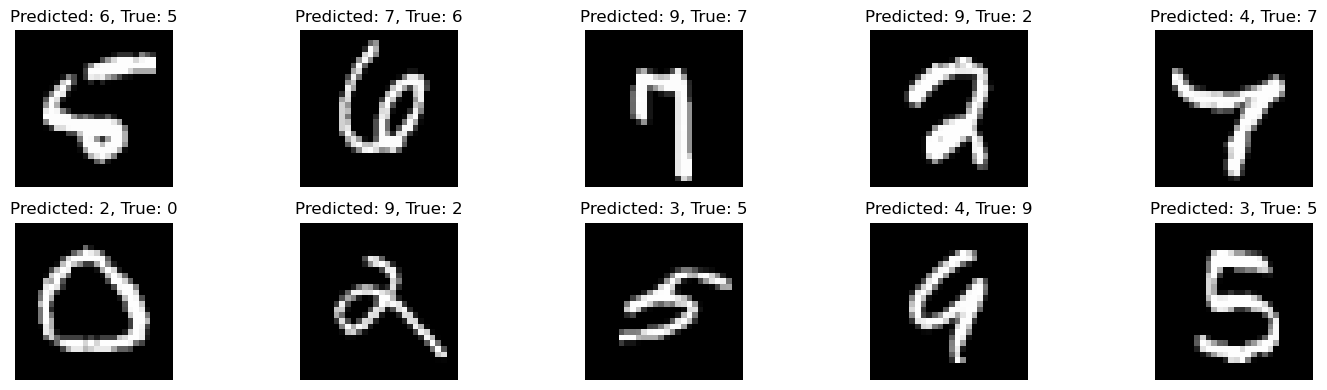

In [11]:
def predict(X, weights, biases):
    activations = feed_forward(X, weights, biases)
    predictions = np.argmax(activations['a3'], axis=1)
    return predictions

def compute_accuracy(predictions, labels):
    accuracy = np.mean(predictions == labels) * 100
    return accuracy

# Flatten the test images and get the true labels
X_test_flattened = t10k_Img.reshape(t10k_Img.shape[0], -1)
predictions = predict(X_test_flattened, train_weights, train_biases)
true_labels = t10k_Lb  # Convert one-hot encoded labels back to normal labels

# Compute the accuracy
test_accuracy = compute_accuracy(predictions, true_labels)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

# Identify misclassified images
misclassified_indices = np.where(predictions != true_labels)[0]
misclassified_images = t10k_Img[misclassified_indices]
misclassified_predictions = predictions[misclassified_indices]
true_misclassified_labels = true_labels[misclassified_indices]

# Plot some of the misclassified images
plt.figure(figsize=(15, 4))
for i, (image, pred, true) in enumerate(zip(misclassified_images[:10], misclassified_predictions[:10], true_misclassified_labels[:10])):
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {pred}, True: {true}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Here, we can see the accuracy is 91.57% and sample set of mis-classified images we can see in above output.